In [1]:
!pip install transformers
!pip install -q datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 5.1 MB/s 
     |████████████████████████████████| 7.6 MB 60.5 MB/s 
     |████████████████████████████████| 182 kB 77.4 MB/s 
     |████████████████████████████████| 452 kB 6.1 MB/s 
     |████████████████████████████████| 132 kB 5.8 MB/s 
     |████████████████████████████████| 212 kB 61.6 MB/s 
     |████████████████████████████████| 127 kB 62.8 MB/s 


In [2]:
from datasets import load_dataset
import torch
import numpy as np
import transformers
import pandas as pd
from transformers import AutoModel, AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

# **Dataset Operations and Preprocessing**

Note: As we were developing this model the emotions dataset had a bug so we used Setfit/emotion insted. [Issue Link](https://github.com/huggingface/datasets/issues/5342)

In [3]:
dataset = load_dataset("SetFit/emotion")
dataset

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/SetFit___json/SetFit--emotion-e444b7640ce3116e/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 16000
    })
    test: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 2000
    })
    validation: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 2000
    })
})

**Tokenization**

In [4]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [5]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [6]:
tokenized = dataset.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

# **Text Classification**

We fine-tune the distilBERT model for emotion analysis.

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # preferred gpu since it is faster

In [8]:
model = (AutoModelForSequenceClassification
         .from_pretrained("distilbert-base-uncased", num_labels=6)
         .to(device))

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'classifier.w

In [9]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

We start with 2 epochs, it can be increased further for better accuracy.

In [10]:
batch_size = 64
logging_steps = len(tokenized["train"]) // batch_size
model_name = "distilbert-base-uncased-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False, 
                                  log_level="error")

In [11]:
trainer = Trainer(model=model, args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=tokenized["train"],
                  eval_dataset=tokenized["validation"],
                  tokenizer=tokenizer)
trainer.train();

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.859700,0.328710,0.905000,0.901558
2,0.251400,0.216559,0.928500,0.928400


In [12]:
preds_output = trainer.predict(tokenized["test"])

In [13]:
preds_output.metrics

{'test_loss': 0.2165587991476059,
 'test_accuracy': 0.9285,
 'test_f1': 0.9284002430408503,
 'test_runtime': 4.2465,
 'test_samples_per_second': 470.978,
 'test_steps_per_second': 7.536}

In [14]:
y_preds = np.argmax(preds_output.predictions, axis=1)

In [15]:
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Oranges", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Confusion matrix")
    plt.show()

In [16]:
y_test = np.array(tokenized["test"]["label"])

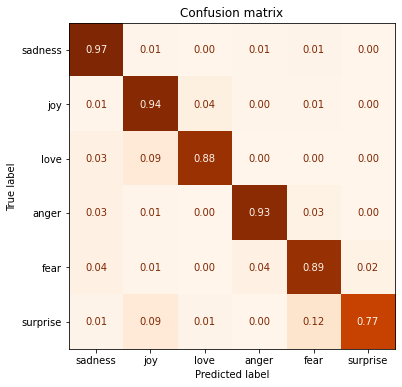

In [17]:
labels = ["sadness","joy", "love", "anger", "fear","surprise"]
plot_confusion_matrix(y_preds, y_test, labels)

# Experimenting

Learning Rate Scheduler

In [24]:
# Define the training arguments as before
batch_size = 64
logging_steps = len(tokenized["train"]) // batch_size
model_name = "distilbert-base-uncased-finetuned-emotion"
training_args_lrs = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=1,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False, 
                                  log_level="error")

In [25]:
from transformers.optimization import Adafactor, AdafactorSchedule

optimizer = Adafactor(model.parameters(), scale_parameter=False, relative_step=False, warmup_init=False, lr=2e-5)
lr_scheduler = AdafactorSchedule(optimizer)

trainer_lrs = Trainer(model=model,args=training_args_lrs, 
                  compute_metrics=compute_metrics,
                  train_dataset=tokenized["train"],
                  eval_dataset=tokenized["test"],
                  tokenizer=tokenizer,
                  optimizers=(optimizer, lr_scheduler))

trainer_lrs.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.093400,0.211843,0.924500,0.925762


TrainOutput(global_step=250, training_loss=0.09340463256835937, metrics={'train_runtime': 121.39, 'train_samples_per_second': 131.807, 'train_steps_per_second': 2.059, 'total_flos': 360171430848000.0, 'train_loss': 0.09340463256835937, 'epoch': 1.0})

Freezing some layers

In [26]:
model_fz = (AutoModelForSequenceClassification
         .from_pretrained("distilbert-base-uncased", num_labels=6)
         .to(device))

In [29]:
for layer in model_fz.distilbert.transformer.layer:
    print(layer)

TransformerBlock(
  (attention): MultiHeadSelfAttention(
    (dropout): Dropout(p=0.1, inplace=False)
    (q_lin): Linear(in_features=768, out_features=768, bias=True)
    (k_lin): Linear(in_features=768, out_features=768, bias=True)
    (v_lin): Linear(in_features=768, out_features=768, bias=True)
    (out_lin): Linear(in_features=768, out_features=768, bias=True)
  )
  (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (ffn): FFN(
    (dropout): Dropout(p=0.1, inplace=False)
    (lin1): Linear(in_features=768, out_features=3072, bias=True)
    (lin2): Linear(in_features=3072, out_features=768, bias=True)
    (activation): GELUActivation()
  )
  (output_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
)
TransformerBlock(
  (attention): MultiHeadSelfAttention(
    (dropout): Dropout(p=0.1, inplace=False)
    (q_lin): Linear(in_features=768, out_features=768, bias=True)
    (k_lin): Linear(in_features=768, out_features=768, bias=True)
    (v_lin):

Freezing first 2 layers bottom-up

In [30]:
for i in range(2):
    for param in model_fz.distilbert.transformer.layer[i].parameters():
        param.requires_grad = False

In [31]:
trainer_frozen = Trainer(model=model_fz, args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=tokenized["train"],
                  eval_dataset=tokenized["validation"],
                  tokenizer=tokenizer)
trainer_frozen.train();

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.929500,0.431944,0.865000,0.858504
2,0.361100,0.309081,0.895500,0.894402
